# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    #x_train = x_input.values
    #x_test = x_test_input.values

    y_train = y_output.values


In [6]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            #self.x = tf.nn.softmax(self.x)
            
            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=0.01, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            #z = tf.clip_by_value(z, -1, 1)
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            #BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            #KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = y))

            #ls = tf.reduce_mean(BCE + KLD + softmax_loss)

            #self.regularized_loss = tf.abs(ls, name = "Regularized_loss")
            self.regularized_loss = tf.clip_by_value(softmax_loss, -1, 1)
            #self.regularized_loss = tf.cond(self.regularized_loss is None, lambda: tf.constant(0.5), lambda: self.regularized_loss )
            
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-3
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            #self.grad = optimizer.compute_gradients(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(y, 1)
        self.actual = tf.argmax(self.y_, 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = pd.DataFrame()

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                
                #batch_iterations = x_train.shape[0]
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    #, summary_str
                    _, train_loss = sess.run([net.train_op,  
                                               net.regularized_loss, 
                                               #net.summary_op
                                              ],
                                              feed_dict={net.x: x_train[i,:], 
                                                         net.y_: y_train[i,:], 
                                                         net.keep_prob:0.5})
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e1):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    
                # summary_str
                valid_accuracy = sess.run(net.tf_accuracy, #, net.summary_op 
                                          feed_dict={net.x: preprocess.x_test, 
                                                     net.y_: preprocess.y_test, 
                                                     net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))

            accuracy, pred_value, actual_value = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual], 
                                                          feed_dict={net.x: preprocess.x_test, 
                                                                     net.y_: preprocess.y_test, 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            
            curr_pred = pd.DataFrame({"{}_{}_{}".format(epochs,f,h):pred_value},)
            Train.predictions = pd.concat([Train.predictions, curr_pred], axis = 1)
            
            if accuracy > Train.best_acc:
                Train.best_acc = accuracy
                Train.pred_value = pred_value
                Train.actual_value = actual_value
                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                #net.saver.save(sess, "dataset/epochs_{}_hidden layers_{}_features count_{}".format(epochs,h,f))
            Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [2, 4, 8, 16]
    hidden_layers_arr = [2, 4, 6]

    epochs = [10]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:10 hidden layers:2 features count:2
Step 1 | Training Loss: 0.337434 | Validation Accuracy: 0.754702
Step 2 | Training Loss: 0.334368 | Validation Accuracy: 0.757984
Step 3 | Training Loss: 0.338247 | Validation Accuracy: 0.757718
Step 4 | Training Loss: 0.335411 | Validation Accuracy: 0.757674
Step 5 | Training Loss: 0.334477 | Validation Accuracy: 0.767300
Step 6 | Training Loss: 0.333484 | Validation Accuracy: 0.759005
Step 7 | Training Loss: 0.328826 | Validation Accuracy: 0.760380
Step 8 | Training Loss: 0.335302 | Validation Accuracy: 0.762997
Step 9 | Training Loss: 0.331089 | Validation Accuracy: 0.761799
Step 10 | Training Loss: nan | Validation Accuracy: 0.569242
Accuracy on Test data: 0.5692423582077026
Current Layer Attributes - epochs:10 hidden layers:2 features count:4
Step 1 | Training Loss: 0.328595 | Validation Accuracy: 0.756698
Step 2 | Training Loss: 0.328897 | Validation Accuracy: 0.756875
Step 3 | Training Loss: 0.341080 | Validat

Step 1 | Training Loss: 0.348964 | Validation Accuracy: 0.761799
Step 2 | Training Loss: 0.341551 | Validation Accuracy: 0.749246
Step 3 | Training Loss: nan | Validation Accuracy: 0.569242
Step 4 | Training Loss: nan | Validation Accuracy: 0.569242
Step 5 | Training Loss: nan | Validation Accuracy: 0.569242
Step 6 | Training Loss: nan | Validation Accuracy: 0.569242
Step 7 | Training Loss: nan | Validation Accuracy: 0.569242
Step 8 | Training Loss: nan | Validation Accuracy: 0.569242
Step 9 | Training Loss: nan | Validation Accuracy: 0.569242
Step 10 | Training Loss: nan | Validation Accuracy: 0.569242
Accuracy on Test data: 0.5692423582077026


In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results

,epoch,no_of_features,hidden_layers,train_score,test_score
0,10,2,2,0.569242,0.569242
1,10,4,2,0.569242,0.569242
2,10,8,2,0.761533,0.761577
3,10,16,2,0.569242,0.569242
4,10,2,4,0.761001,0.761001
5,10,4,4,0.763352,0.763307
6,10,8,4,0.569242,0.569242
7,10,16,4,0.569242,0.569242
8,10,2,6,0.761666,0.761666
9,10,4,6,0.569242,0.569242


In [12]:
Train.predictions.to_pickle("dataset/tf_vae_dense_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.6402  0.3598]
 [ 0.074   0.926 ]]


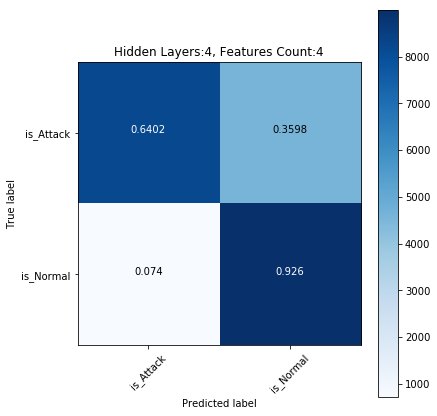

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)